In [93]:
import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import datetime
import glob
from matplotlib.colors import Normalize
import PIL
import cv2

In [94]:
def set_axis(x, no_labels = 7)->tuple[np.array, np.array]:
    """Sets the x-axis positions and labels for a plot.

    Args:
        x (np.array): The x-axis data.
        no_labels (int, optional): The number of labels to display. Defaults to 7.

    Returns:
        tuple[np.array, np.array]: A tuple containing:
            - The positions of the labels on the x-axis.
            - The labels themselves.
    """
    nx = x.shape[0]
    step_x = int(nx / (no_labels - 1))
    x_positions = np.arange(0,nx,step_x)
    x_labels = x[::step_x]
    return x_positions, x_labels

In [210]:
path_out = "./Martyna/"
# path_out = "./Maria2/"
# path_out = "./Maria/"
# path_out = "./Wika/"
# path_out = "./Mateusz/"
files = glob.glob(path_out + "*")
files.sort()

In [211]:
dx = 5.106500953873407
dt = 0.0016


data = []
first_filename = files[0]
for file in files:
    data.append(np.load(file))
data = np.concatenate(data)
time_start = datetime.datetime.strptime(
    "2024-05-07 " + first_filename.split("\\")[-1].split(".")[0], "%Y-%m-%d %H%M%S"
)
index = pd.date_range(start=time_start, periods=len(data), freq=f"{dt}s")


columns = np.arange(len(data[0])) * dx


df = pd.DataFrame(data=data, index=index, columns=columns)

In [212]:
def plot_image(img, a=6, b=9, lines=None, title="DataFrame Visualization", velocities=None):
    """
    Plots a DataFrame as an image with continuous coloring based on the range of values
    using normalization.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the image data with numeric values.
    """
    # Normalize the data to the range [0, 1]
    norm = Normalize(vmin=img.min().min(), vmax=img.max().max())
    
    # Create the plot
    plt.figure(figsize=(a, b))
    plt.imshow(img, cmap='viridis', aspect='auto', norm=norm,  interpolation="none")
    
    if lines is not None:
        for i, line in enumerate(lines):
            x1, y1, x2, y2 = line[0]
            plt.plot([x1, x2], [y1, y2], color='red', linewidth=2)

            # Annotate velocity
            if velocities is not None:
                mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
                plt.text(mid_x, mid_y, f"{velocities[i]:.2f} km/h", color="cyan", fontsize=10, ha="center", va="center")


    # plt.colorbar(label='Value')
    plt.title(title)
    if velocities is not None:
        plt.colorbar(label="Intensity")
        plt.xlabel("Columns (Space)")
        plt.ylabel("Rows (Time)")
        plt.axis("on")
    else:
        plt.axis('off')  # Turn off axis labels for better image representation
    # Display the plot
    plt.show()

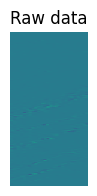

In [213]:
plot_image(df.values, a=1, b=2, title="Raw data")

In [214]:
df = pd.DataFrame(data=data, index=index, columns=columns)
df.shape

(75000, 52)

In [215]:
#RESIZING =>DECIMATION WITH LANCZOS INTERPOLATION❤️🦎
df = cv2.resize(df.values, (50, 1000), interpolation=cv2.INTER_LANCZOS4)
print(f"Shape of the resized df: {df.shape}")


Shape of the resized df: (1000, 50)


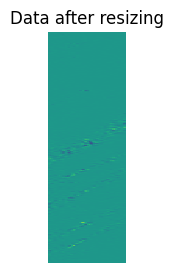

In [216]:
plot_image(df,a=1,b=3, title="Data after resizing")


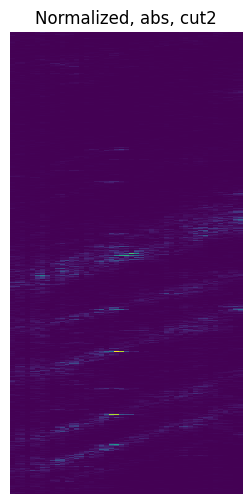

In [217]:
# df = pd.DataFrame(data=data, index=index, columns=columns)
df = pd.DataFrame(df)
df = df.iloc[:, 3:]  #DELETE FIRST 2 COLUMNS, -IT HAS NOISE, AND ITS 
#                   NOT THAT RELEVANT FOR DETECTION OF LINES❤️🦎

#ARITHMETIC OPERATIONS
df = np.abs(df)  #ABSOLUTELY NECESSARY  ❤️🦎

#NORMALIZE values to 0,255
normalized_image = cv2.normalize(df.values, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
df = pd.DataFrame(normalized_image)
plot_image(df,a=3, b=6, title="Normalized, abs, cut2")


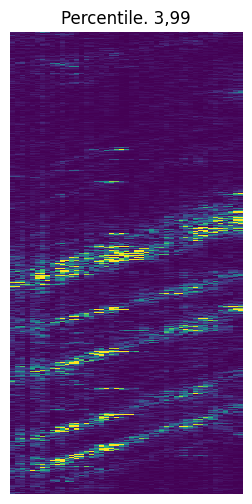

(1000, 47)


In [218]:

#CLIP PERCENTILES FOR OUTLIERS ❤️🦎 - CRUCIAL
low, high = np.percentile(df, [3,99]).astype(np.float32)
df[:] = df.apply(lambda col: np.where(((col < low)), 0, col))
df.clip(upper = high, inplace=True)

plot_image(df.values, a=3,b=6, title="Percentile. 3,99")
print(df.shape)
df_normalized = df


df_orginal = df  #NEEDED FOR FINAL VIS ❤️🦎

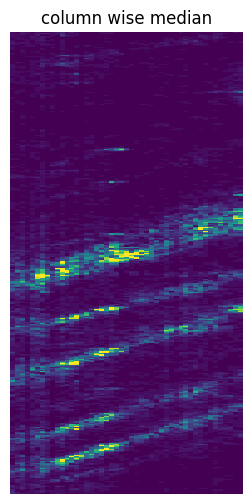

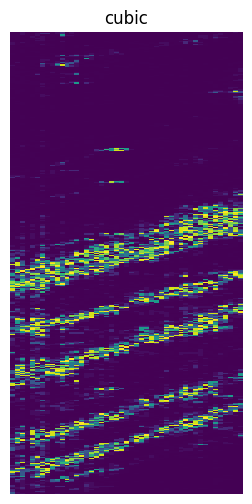

In [219]:

def column_wise_median_filter(df, kernel_size=5):
    """
    Applies a median filter to each column in the DataFrame.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame.
        kernel_size (int): Size of the median filter window (must be odd).
    
    Returns:
        pd.DataFrame: Denoised DataFrame.
    """
    filtered_data = df.copy()
    
    for col in df.columns:
        filtered_data[col] = cv2.medianBlur(df[col].values.astype(np.uint8), kernel_size)
    
    return filtered_data

# Apply the median filter
df_denoised = column_wise_median_filter(df_normalized, kernel_size=5)

# Visualize the result
plot_image(df_denoised.values, a=3, b=6, title="column wise median")
df_squared = df_denoised **3
plot_image(df_squared.values, a=3, b=6, title="cubic")
# print(df_squared.max(axis=1))

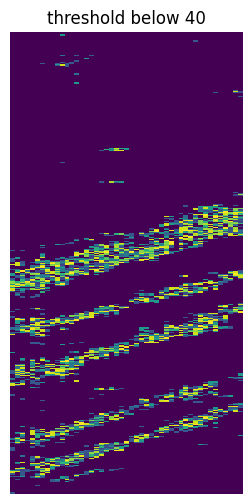

In [220]:
df_squared[:] = df_squared.apply(lambda col: np.where(((col < 40)), 0, col))
plot_image(df_squared.values,3, 6, title="threshold below 40")

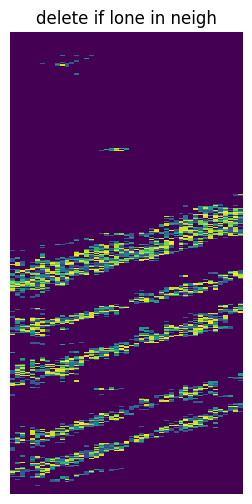

In [221]:
def set_pixel_zero_based_on_neighborhood(image, neighborhood_size=(50, 10), min_count=20):
   
    output_image = image.copy()
    h, w = image.shape
    nh, nw = neighborhood_size
    
    for y in range(h):
        for x in range(w):
            # Define the neighborhood boundaries
            y1 = max(y - nh // 2, 0)
            y2 = min(y + nh // 2 + 1, h)
            x1 = max(x - nw // 2, 0)
            x2 = min(x + nw // 2 + 1, w)
            
            # Extract the neighborhood
            neighborhood = image[y1:y2, x1:x2]
            
            # Count the number of non-zero pixels in the neighborhood
            if cv2.countNonZero(neighborhood) < min_count:
                output_image[y, x] = 0
    
    return output_image
denois = set_pixel_zero_based_on_neighborhood(df_squared.values)
plot_image(denois, 3, 6, title="delete if lone in neigh")
denois = pd.DataFrame(denois)

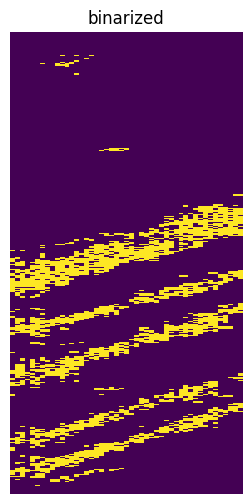

In [222]:
#BINARIZATION
df_binarized = (denois > 0).astype(int)
plot_image(df_binarized.values,a=3,b=6, title="binarized")

In [223]:
# # Perform morphological closing to fill holes in the binary image
# kernel = np.ones((3, 3), np.uint8)  # Define a kernel for the morphological operation
# closed_image = cv2.morphologyEx(df_binarized.values.astype(np.uint8), cv2.MORPH_CLOSE, kernel, iterations=1)

# print("Connected lines after closing")
# plot_image(closed_image, 3, 6)

In [224]:
# #OPENING FOR NOISE REDUCTION
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
# opening = cv2.morphologyEx(closed_image.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=1)
# print("opening")
# plot_image(pd.DataFrame(opening), 3, 6)

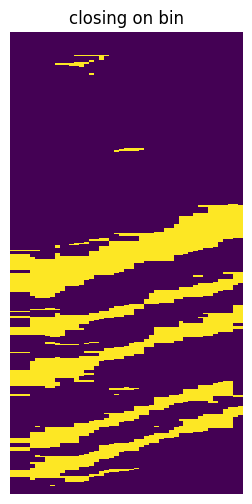

In [225]:
#CLOSING ON CANNY == CLOSING ON BINARIZED DF

# edges = cv2.Canny(denois.values.astype(np.uint8), 50, 100)

# if edges is not None and np.any(edges):
#     edges_df = pd.DataFrame(edges)
#     plot_image(edges_df, a=3, b=6, title="edges")
# else:
#     print("No edges were detected.")
    
kernel = np.ones((3, 2), np.uint8)

closed_bin = cv2.morphologyEx(df_binarized.values.astype(np.uint8), cv2.MORPH_CLOSE, kernel, iterations=3)
plot_image(closed_bin, 3, 6, title="closing on bin")

# edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=3)
# plot_image(edges_closed_bin, 3, 6, title="closing ")

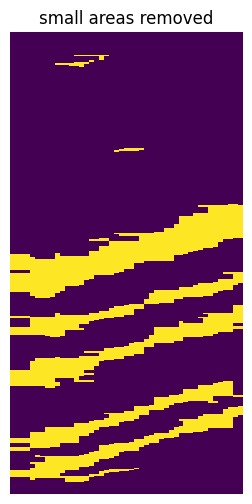

In [226]:
def remove_small_areas(binary_image, min_area=100):
    num_labels, labels = cv2.connectedComponents(binary_image)
    output_image = np.zeros_like(binary_image, dtype=np.uint8)
    
    for label in range(1, num_labels):
        region = (labels == label).astype(np.uint8)
        if cv2.countNonZero(region) >= min_area:
            output_image[region == 1] = 255
    
    return output_image

remove_small = remove_small_areas(closed_bin, 30)
plot_image(remove_small, 3,6,title="small areas removed")

-------
-------
-------

In [227]:
def plot_connected_components(binary_image):
    # Find connected components and their labels
    num_labels, labels = cv2.connectedComponents(binary_image)

    # Plot each connected component separately
    for label in range(1, num_labels):  # Start from 1 to skip the background
        region = (labels == label).astype(np.uint8) * 255  # Extract the region and scale to 255
        plot_image(region, 1,2)
# plot_connected_components(remove_small)


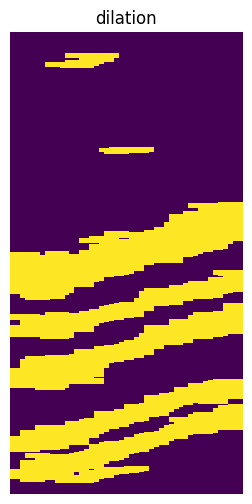

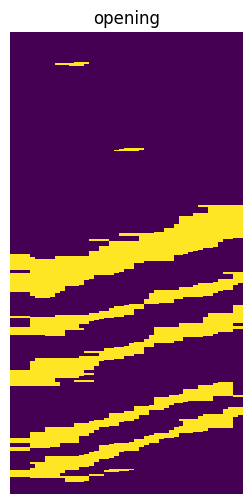

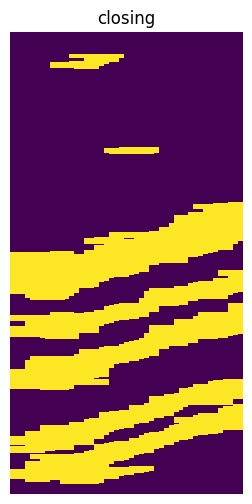

In [228]:
kernel = np.ones((5,3), np.uint8)
edges_dilated = cv2.dilate(remove_small, kernel, iterations=2)
plot_image(edges_dilated, 3, 6, title='dilation')

kernel = np.ones((3, 3), np.uint8)
edges_opened = cv2.morphologyEx(remove_small, cv2.MORPH_OPEN, kernel, iterations=1)
plot_image(edges_opened, 3, 6, title="opening")

kernel = np.ones((2,2), np.uint8)
edges_closed = cv2.morphologyEx(edges_dilated, cv2.MORPH_CLOSE, kernel, iterations=1)
plot_image(edges_closed, 3, 6, title="closing")

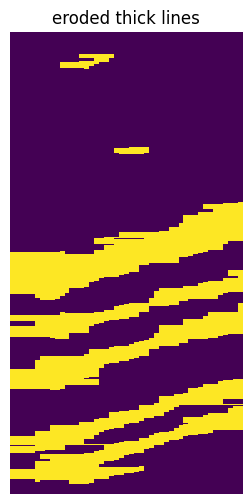

In [229]:
kernel = np.ones((1,3), np.uint8)
edges_eroded = cv2.erode(edges_closed, kernel, iterations=2)
plot_image(edges_eroded, 3,6,title="eroded thick lines")

krowa
krowa


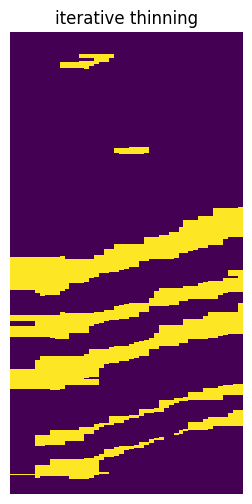

In [230]:
import numpy as np
import matplotlib.pyplot as plt

def erode_wide_lines(binary_image, min_line_width=5, kernel_size=3, iterations=1):
    num_labels, labels = cv2.connectedComponents(binary_image)
    mask = np.zeros_like(binary_image, dtype=np.uint8)
    
    for label in range(1, num_labels):
        region = (labels == label).astype(np.uint8)
        if cv2.countNonZero(region) >= min_line_width:
            print("krowa")
            mask[region == 1] = 1
    
    kernel = np.ones((5, 1), np.uint8)
    eroded_image = cv2.erode(binary_image, kernel, iterations=iterations)
    result_image = np.where(mask == 1, eroded_image, binary_image)
    result_image = (result_image * 255).astype(np.uint8)
    
    return result_image

# Example usage
iterative_thinning = erode_wide_lines(edges_eroded, min_line_width=3000, kernel_size=3, iterations=5)
plot_image(iterative_thinning, 3, 6, title="iterative thinning")

# Can be useful for velocity graph calculation

In [231]:
# from skimage.morphology import thin
# thinned = thin(edges_closed_bin).astype(np.uint8)
# plot_image(thinned, 3, 6, title="thined")

In [232]:
# import cv2
# import numpy as np
# from skimage.morphology import skeletonize, thin
# from skimage.measure import label, regionprops
# from skimage.morphology import medial_axis

# def extract_longest_branch(image):
#     """
#     Extracts the longest path from a skeletonized binary image and prunes smaller branches.
    
#     Parameters:
#         image (numpy.ndarray): Binary input image (grayscale, 0 and 255 values).
        
#     Returns:
#         numpy.ndarray: Binary output image with the main structure intact (0 and 255 values).
#     """
#     # Ensure binary and skeletonize
#     binary = image.astype(np.uint8)  # Convert to binary
#     skeleton = skeletonize(binary).astype(np.uint8)
    
#     # Iteratively prune branches based on length
#     while True:
#         # Label connected components in the skeleton
#         labeled_skeleton = label(skeleton, connectivity=2)
#         regions = regionprops(labeled_skeleton)
        
#         # Find the smallest branch
#         min_area = np.inf
#         smallest_label = None
#         for region in regions:
#             if region.area < min_area:
#                 min_area = region.area
#                 smallest_label = region.label
        
#         # Stop if no small branches remain
#         if min_area >= 20:  # Adjust threshold as needed
#             break
        
#         # Remove the smallest branch
#         skeleton[labeled_skeleton == smallest_label] = 0

#     # Convert back to 0-255 format
#     skeleton = (skeleton * 255).astype(np.uint8)
#     return skeleton


# skeleton_full =  skeletonize(edges_opened).astype(np.uint8)
# plot_image(skeleton_full, 9,12, title="skeleton")

# skeleton = extract_longest_branch(edges_opened)
# plot_image(skeleton, 9,12, title="pruned")

In [233]:
# def skeletonize(img):
#     s1 = np.array([[-1, -1, -1], 
#                    [0, 1, 0], 
#                    [1, 1, 1]], dtype = np.int8)
#     s2 = np.array([[0, -1, -1], 
#                    [1, 1, -1], 
#                    [0, 1, 0]], dtype = np.int8)
#     skeleton = np.copy(img)
    
#     change = True
#     while change:
#         change = False
#         for i in range(4):
#             thin1 = cv2.morphologyEx(skeleton.astype(np.uint8), cv2.MORPH_HITMISS, s1)
#             thin1 = np.logical_and(skeleton, np.logical_not(thin1))
#             if not np.array_equal(thin1, skeleton):
#                 change = True
#             skeleton = thin1
            
#             thin2 = cv2.morphologyEx(skeleton.astype(np.uint8), cv2.MORPH_HITMISS, s2)
#             thin2 = np.logical_and(skeleton, np.logical_not(thin2))
#             if not np.array_equal(thin2, skeleton):
#                 change = True
#             skeleton = thin2
                        
#             s1 = np.rot90(s1)
#             s2 = np.rot90(s2)
        
    
#     return skeleton

# import cv2
# import numpy as np
# from skimage.morphology import skeletonize
# from skimage.measure import label, regionprops

# def extract_longest_branch(binary):
#     """
#     Extracts the longest branch from a skeletonized binary image.
    
#     Parameters:
#         image (numpy.ndarray): Binary input image (grayscale, 0 and 255 values).
        
#     Returns:
#         numpy.ndarray: Binary output image with only the longest branch (0 and 255 values).
#     """
#     # Skeletonize the binary image
#     skeleton = skeletonize(binary // 255)
    
#     # Label connected components in the skeleton
#     labeled_skeleton = label(skeleton)
    
#     # Find the longest branch
#     longest_label = None
#     max_length = 0
#     for region in regionprops(labeled_skeleton):
#         if region.area > max_length:
#             max_length = region.area
#             longest_label = region.label
    
#     # Create a mask for the longest branch
#     longest_branch_mask = (labeled_skeleton == longest_label).astype(np.uint8)
    
#     # Convert back to displayable format (0 and 255 values)
#     return longest_branch_mask * 255


# # Extract the longest branch


# # Display or save the result
# cv2.imshow('Longest Branch', longest_branch)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


# skeleton = skeletonize(edges_closed).astype(np.uint8)
# plot_image(skeleton, 9,12, title='skeleton diy')

------------------
------------------
------------------
# 5:25, good hugh, mergign doesnt work

In [234]:
# edges_closed_bin = cv2.resize(edges_closed_bin, (200,200), interpolation = cv2.INTER_LANCZOS4)
# plot_image(edges_closed_bin, a=3,b=6, title="lanczos")


In [235]:


# lines = cv2.HoughLinesP(edges_closed_bin, rho=1, theta=np.pi / 180, threshold=7, minLineLength=30, maxLineGap=7)
# plot_image(cv2.resize(df_normalized.values, (200,200), interpolation=cv2.INTER_LANCZOS4), a=7, b= 7, lines = lines, title="Connected Lines with Hough Transform")

In [236]:
# def merge_lines(lines, min_distance=30, max_angle_diff=25):
#     """
#     Groups lines that are close together and have similar angles, then selects
#     the line with the most left and most right coordinates in each group.

#     Parameters:
#     lines (list): List of lines detected by HoughLinesP (x1, y1, x2, y2).
#     min_distance (float): Minimum distance to consider two lines as part of the same group.
#     max_angle_diff (float): Maximum angle difference (in degrees) to group lines.

#     Returns:
#     list: A list of selected lines represented as [[[x1, y1, x2, y2]], ...].
#     """
#     if lines is None or len(lines) == 0:
#         return []

#     merged_groups = []

#     for line in lines:
#         x1, y1, x2, y2 = line[0]
#         angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
#         length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)  # Calculate line length
#         midpoint = ((x1 + x2) / 2, (y1 + y2) / 2)  # Calculate midpoint
#         added = False

#         for group in merged_groups:
#             gx1, gy1, gx2, gy2, gangle, glines = group
#             group_midpoint = ((gx1 + gx2) / 2, (gy1 + gy2) / 2)
#             group_distance = np.sqrt(
#                 (midpoint[0] - group_midpoint[0]) ** 2
#                 + (midpoint[1] - group_midpoint[1]) ** 2
#             )

#             if group_distance < min_distance and abs(gangle - angle) < max_angle_diff:
#                 # Add the line to this group
#                 group[0] = min(gx1, x1, x2)  # Update group boundaries
#                 group[1] = min(gy1, y1, y2)
#                 group[2] = max(gx2, x1, x2)
#                 group[3] = max(gy2, y1, y2)
#                 group[4] = (gangle + angle) / 2  # Average the angles
#                 group[5].append((x1, y1, x2, y2))  # Add line coordinates
#                 added = True
#                 break

#         if not added:
#             # Create a new group for this line
#             merged_groups.append([x1, y1, x2, y2, angle, [(x1, y1, x2, y2)]])

#     # Select the line with the most left and most right coordinates from each group
#     selected_lines = []
#     for group in merged_groups:
#         group_lines = group[5]  # All lines in the group

#         # Determine the overall leftmost and rightmost points
#         leftmost = min((line[0], line[1]) for line in group_lines)
#         rightmost = max((line[2], line[3]) for line in group_lines)

#         # Form a new line from the leftmost to the rightmost point
#         selected_lines.append([[leftmost[0], leftmost[1], rightmost[0], rightmost[1]]])
#     return selected_lines


In [237]:
# merged_lines = merge_lines(lines)

# # Plot merged lines
# plot_image(cv2.resize(df_normalized.values, (200,200), interpolation=cv2.INTER_LANCZOS4), a= 7, b= 7, lines = merged_lines, title="Merged Lines with Hough Transform")

------------------
------------------
------------------


In [238]:
# img = edges_closed
# num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img, connectivity=8)

# # Filter out small regions based on area
# for label in range(1, num_labels):  # Start from 1 to skip the background
#     if stats[label, cv2.CC_STAT_AREA] < 20:
#         img[labels == label] = 0
# plot_image(img, 3, 6, title="delete small area")

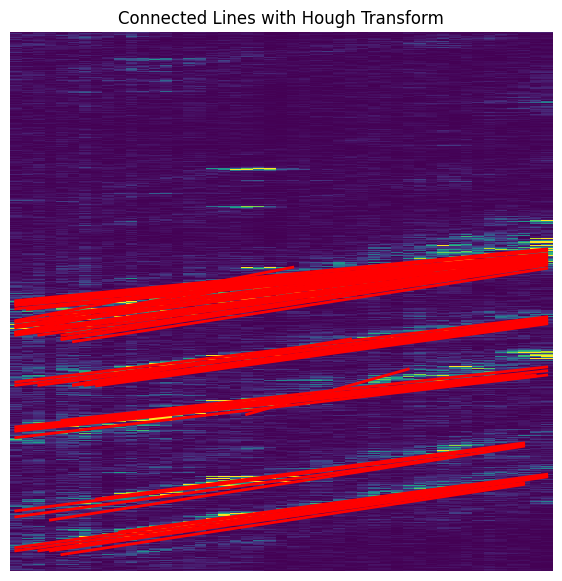

In [239]:
lines = cv2.HoughLinesP(remove_small, rho=1, theta=np.pi / 180, threshold=5, minLineLength=80, maxLineGap=25)
plot_image(df_normalized.values, a=7, b= 7, lines = lines, title="Connected Lines with Hough Transform")

# filtered_lines = []
# for line in lines:
#     if line[0][0] != line[0][2]:
#         filtered_lines.append(line)
# plot_image(df_normalized.values, a=7, b= 7, lines = filtered_lines, title="Connected Lines with Hough Transform")


[[[0, 502, 46, 432]], [[5, 574, 46, 438]], [[0, 956, 46, 825]], [[0, 649, 46, 541]], [[0, 732, 46, 636]], [[0, 888, 44, 768]], [[0, 498, 46, 413]]]


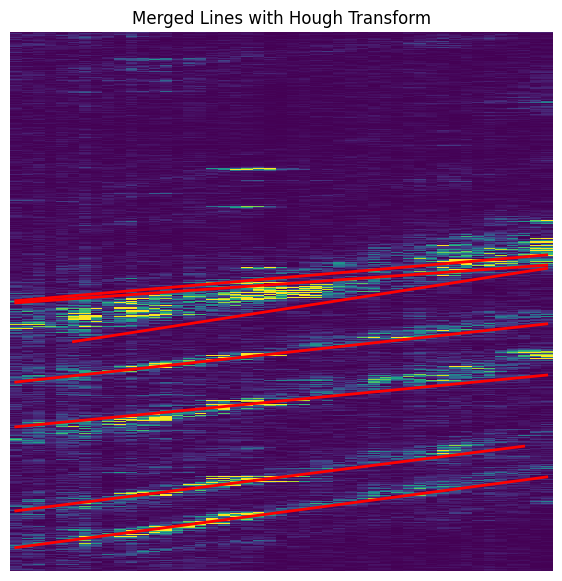

In [240]:
def merge_lines(lines, min_distance=30, max_angle_diff=25):
    """
    Groups lines that are close together and have similar angles, then selects
    the line with the most left and most right coordinates in each group.

    Parameters:
    lines (list): List of lines detected by HoughLinesP (x1, y1, x2, y2).
    min_distance (float): Minimum distance to consider two lines as part of the same group.
    max_angle_diff (float): Maximum angle difference (in degrees) to group lines.

    Returns:
    list: A list of selected lines represented as [[[x1, y1, x2, y2]], ...].
    """
    if lines is None or len(lines) == 0:
        return []

    merged_groups = []

    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x1 == x2:
            continue
        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
        length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)  # Calculate line length
        midpoint = ((x1 + x2) / 2, (y1 + y2) / 2)  # Calculate midpoint
        added = False

        for group in merged_groups:
            gx1, gy1, gx2, gy2, gangle, glines = group
            group_midpoint = ((gx1 + gx2) / 2, (gy1 + gy2) / 2)
            group_distance = np.sqrt(
                (midpoint[0] - group_midpoint[0]) ** 2
                + (midpoint[1] - group_midpoint[1]) ** 2
            )

            if group_distance < min_distance and abs(gangle - angle) < max_angle_diff:
                # Add the line to this group
                group[0] = min(gx1, x1, x2)  # Update group boundaries
                group[1] = min(gy1, y1, y2)
                group[2] = max(gx2, x1, x2)
                group[3] = max(gy2, y1, y2)
                group[4] = (gangle + angle) / 2  # Average the angles
                group[5].append((x1, y1, x2, y2))  # Add line coordinates
                added = True
                break

        if not added:
            # Create a new group for this line
            merged_groups.append([x1, y1, x2, y2, angle, [(x1, y1, x2, y2)]])

    # Select the line with the most left and most right coordinates from each group
    selected_lines = []
    for group in merged_groups:
        group_lines = group[5]  # All lines in the group

        # Determine the overall leftmost and rightmost points
        leftmost = min((line[0], line[1]) for line in group_lines)
        rightmost = max((line[2], line[3]) for line in group_lines)

        # Form a new line from the leftmost to the rightmost point
        selected_lines.append([[leftmost[0], leftmost[1], rightmost[0], rightmost[1]]])
    return selected_lines

merged_lines = merge_lines(lines)
print(merged_lines)
# Plot merged lines
plot_image(df_normalized.values, a= 7, b= 7, lines = merged_lines, title="Merged Lines with Hough Transform")

In [241]:
df.shape

(1000, 47)

In [242]:
#FAJNY KOD DO USTAWIENIA DX I DT

# Original values
original_dx = 5.106500953873407
original_dt = 0.0016
original_shape = (75000, 52)  # (rows, columns)

# New dataframe shape
new_shape = df.shape  # (rows, columns)

# Calculate new dx and dt
new_dt = original_dt * (original_shape[0] / new_shape[0])
new_dx = original_dx * (original_shape[1] / new_shape[1])

print(f"New dx: {new_dx:.3f} meters/column")
print(f"New dt: {new_dt:.3f} seconds/row")


New dx: 5.650 meters/column
New dt: 0.120 seconds/row


In [243]:
def calculate_velocities(lines, dx, dt):
    """
    Calculate velocities for each line based on its slope.

    Parameters:
        lines (list): List of merged lines in the format [[[x1, y1, x2, y2]], ...].
        dx (float): Spatial resolution (distance per column).
        dt (float): Temporal resolution (time per row).

    Returns:
        list: A list of velocities corresponding to each line.
    """
    velocities = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x2 != x1:  # Avoid division by zero
            slope = (y2 - y1) / (x2 - x1)  # Slope in pixels
            velocity = abs(dx / (slope * dt)) * 3.6  # Convert to km/h
            velocities.append(velocity)
        else:
            velocities.append(None)  # Vertical line: undefined velocity
    return velocities

velocities = calculate_velocities(merged_lines, new_dx, new_dt)
print(velocities)




[111.38070165652148, 51.09696511416507, 59.51640546531683, 72.19119551811578, 81.21509495788025, 62.147203098204024, 91.72528371713534]


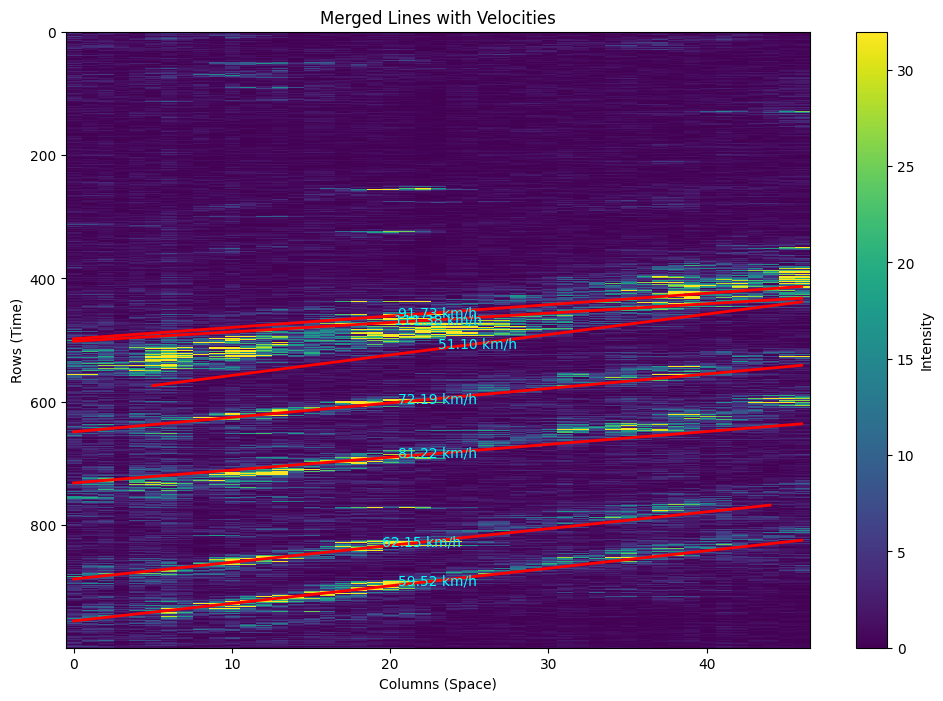

In [244]:
plot_image(df_orginal, a=12,b=8,lines=merged_lines, title="Merged Lines with Velocities",velocities=velocities)

erosion


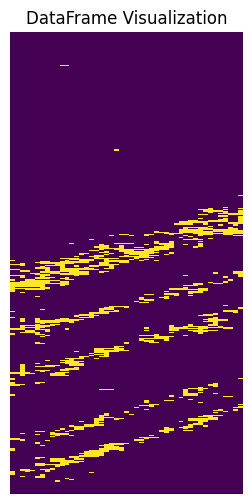

In [245]:
#EROSION, 
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
eroded_image = cv2.erode(df_binarized.values.astype(np.uint8), kernel, iterations=1)
df_eroded = pd.DataFrame(eroded_image, columns=df.columns)
print("erosion")
plot_image(df_eroded,3,6)

dilation


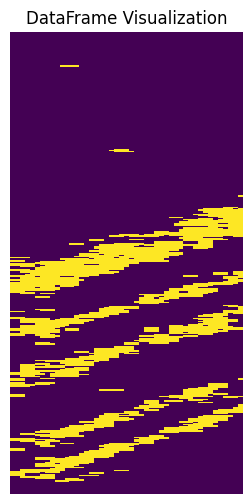

In [246]:
#DILATION
kernel_diagonal = np.ones((2,2), dtype=np.uint8)
# for i in range(20):
#     kernel_diagonal[i, min(i, 4)] = 1
kernel_flip =  np.flip(kernel_diagonal,axis=1 )
# print(kernel_flip)
img_bin_dil = cv2.dilate(df_eroded.values.astype(np.uint8), kernel_flip, iterations=2)   #i have like 20 pixels gaps on vertical. 
df_dilated = pd.DataFrame(img_bin_dil, columns=df.columns)
print("dilation")
plot_image(df_dilated,3,6)

smooth edges


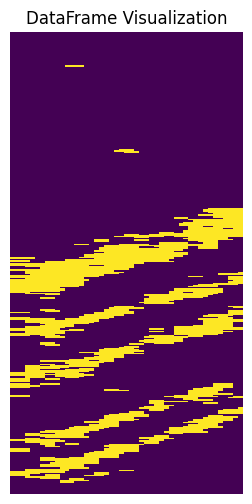

In [247]:
# CLOSE VERTICAL
vertical_kernel = np.ones((2, 2), dtype=np.uint8)
closed_image = cv2.morphologyEx(df_dilated.values.astype(np.uint8), cv2.MORPH_CLOSE, vertical_kernel)
print("smooth edges")
df_smooth = pd.DataFrame(closed_image, columns = df.columns)
plot_image(df_smooth,3,6)